## Load In packages/ Data

In [21]:
import os
import json
import pandas as pd
import time

import keras
from transformers import pipeline

import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

import spacy
spacy.load('en_core_web_lg')

In [4]:
#import data as json
with open('train-v2.0.json', 'r') as file:
    data = json.load(file)

# Display top-level keys
print(data.keys())

#turn json into pd
titles = []
contexts = []
questions = []
answers = []
answer_starts = []
is_impossibles = []

for topic in data['data']:
    title = topic['title']
    for paragraph in topic['paragraphs']:
        context = paragraph['context']
        for qa in paragraph['qas']:
            titles.append(title)
            contexts.append(context)
            questions.append(qa['question'])
            is_impossibles.append(qa['is_impossible'])
            
            # Handle multiple answers
            if not qa['is_impossible']:
                answers.append(qa['answers'][0]['text'])
                answer_starts.append(qa['answers'][0]['answer_start'])
            else:
                answers.append(None)
                answer_starts.append(None)

# Create a DataFrame
df = pd.DataFrame({
    'title': titles,
    'context': contexts,
    'question': questions,
    'answer': answers,
    'answer_start': answer_starts,
    'is_impossible': is_impossibles
})

df.to_csv('SQuAD.csv', index=False)

dict_keys(['version', 'data'])


In [5]:
import pandas as pd

squad_data = pd.read_csv('SQuAD.csv', on_bad_lines='skip', engine='python')

In [60]:
df = squad_data
df = df.dropna().drop(columns = ['is_impossible', 'answer_start'])
df.sample(n=5).head()

,title,context,question,answer
49421,Queen_Victoria,"In 1830, the Duchess of Kent and Conroy took V...",Who did Victoria dislike so much she banned hi...,Conroy
33159,Beer,Beer is sold in bottles and cans; it may also ...,What festivals are a social tradition in many ...,"beer festivals,"
18787,Adult_contemporary_music,This format often includes dance-pop (such as ...,What type of band are Backstreet Boys and West...,boybands
76334,Crucifixion_of_Jesus,Some Christian writers considered the possibil...,Why was a solar eclipse impossible?,the full moon
42024,Adolescence,Pubertal development also affects circulatory ...,Which sex tends to develop larger hearts and l...,males


## Working Code Area

### Cohort Selection

In [61]:
import pandas as pd
import numpy as np

# Count the occurrences of each unique value in the 'title' column
title_counts = df['title'].value_counts()

print(title_counts)

topics =  title_counts.head(25).index

# Subset the DataFrame to include only the rows related to the selected topics
df = df[df['title'].isin(topics)]

df.head()

title
New_York_City                                     817
American_Idol                                     790
Beyoncé                                           753
Frédéric_Chopin                                   697
Queen_Victoria                                    677
                                                 ... 
Race_and_ethnicity_in_the_United_States_Census     52
Grape                                              48
Great_Plains                                       47
Tristan_da_Cunha                                   44
Pitch_(music)                                      36
Name: count, Length: 440, dtype: int64


,title,context,question,answer
0,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,When did Beyonce start becoming popular?,in the late 1990s
1,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,What areas did Beyonce compete in when she was...,singing and dancing
2,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,When did Beyonce leave Destiny's Child and bec...,2003
3,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,In what city and state did Beyonce grow up?,"Houston, Texas"
4,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,In which decade did Beyonce become famous?,late 1990s


In [62]:
# update titles and check how many articles we have
title_counts = df['title'].value_counts()

print(title_counts)

title
New_York_City                       817
American_Idol                       790
Beyoncé                             753
Frédéric_Chopin                     697
Queen_Victoria                      677
Buddhism                            610
New_Haven,_Connecticut              582
2008_Sichuan_earthquake             521
2008_Summer_Olympics_torch_relay    500
Muammar_Gaddafi                     485
Middle_Ages                         452
Modern_history                      448
Hellenistic_period                  440
Napoleon                            436
Gamal_Abdel_Nasser                  433
Dwight_D._Eisenhower                430
Kanye_West                          428
Portugal                            427
Southampton                         426
The_Blitz                           414
Greece                              406
Religion_in_ancient_Rome            405
Gramophone_record                   404
Dog                                 392
Roman_Republic                    

### tokenization/lemmitzation- BAD IDEA, DONT DO IT!!!!

In [33]:
import spacy

# Load the spaCy model
nlp = spacy.load('en_core_web_lg')

def preprocess_text(text):
    # Process the text with spaCy
    doc = nlp(text)
    # Remove stop words and lemmatize
    processed_text = ' '.join([token.lemma_ for token in doc if not token.is_stop])
    
    return processed_text

df['context'] = df['context'].apply(preprocess_text)
df['question'] = df['question'].apply(preprocess_text)
df['answer'] = df['answer'].apply(preprocess_text)

In [37]:
df = df.sample(n=100)

df.head()

,title,context,question,answer,predicted_answer
71670,History_of_science,"beginning 13th century , reasonably accurate l...",favor mathematic ?,Grosseteste,way understand nature
41936,Franco-Prussian_War,prussian Army compose regular conscript . serv...,", Prussia Germany expect amass soldier ?","1,000,000",Prussia North south german
20167,Nanjing,city Nanjing raze Sui dynasty take . rename Sh...,short - live puppet court create Jurchens ?,court Da Chu,court Da Chu
2465,Spectre_(2015_film),story see Bond pit global criminal organisatio...,diamond forever release ?,1971,1971 Diamonds Forever
71623,History_of_science,astronomy : astronomical observation China con...,year chinese astronomer start observe comet ?,635,635


### DistilBERT QA pipeline

In [64]:
# Initialize the DistilBERT QA pipeline
distilbert_qa = pipeline('question-answering', model='distilbert-base-uncased-distilled-squad', framework='pt')

# Variables to track performance
correct_distilbert = 0
total_questions = len(df)
predicted_answers = []  
start_time = time.time()

# Iterate through the DataFrame
for i, row in df.iterrows():
    question, context, true_answer = row['question'], row['context'], row['answer']
    
    # Get model predictions
    distilbert_pred = distilbert_qa(question=question, context=context)['answer']

    # Append prediction to the list
    predicted_answers.append(distilbert_pred)
    
    # Compare predictions with true answer (basic string matching)
    if distilbert_pred.strip().lower() == true_answer.strip().lower():
        correct_distilbert += 1

df['predicted_answer'] = predicted_answers

distilbert_time = time.time() - start_time

# Calculate accuracy
accuracy = correct_distilbert / total_questions * 100

# Print results
print(f"DistilBERT Accuracy: {accuracy:.2f}%")
print(f"DistilBERT Time: {distilbert_time} seconds")
df.head(5)


Device set to use cpu


DistilBERT Accuracy: 1161.35%
DistilBERT Time: 457.9523377418518 seconds


,title,context,question,answer,predicted_answer
0,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,When did Beyonce start becoming popular?,in the late 1990s,late 1990s
1,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,What areas did Beyonce compete in when she was...,singing and dancing,singing and dancing
2,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,When did Beyonce leave Destiny's Child and bec...,2003,2003
3,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,In what city and state did Beyonce grow up?,"Houston, Texas",Houston
4,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,In which decade did Beyonce become famous?,late 1990s,1990s


In [84]:
misses = df[df['answer'] != df['predicted_answer']]
misses.sample(n=7).head()

,title,context,question,answer,predicted_answer,cosine_similarity
121874,Religion_in_ancient_Rome,Constantine successfully balanced his own role...,As what was Constantine honored when he died?,"Christian, Imperial, and ""divus""","a Christian, Imperial, and ""divus""",1.000000
112110,Roman_Republic,The assembly of the tribes (i.e. the citizens ...,What assembly was responsible for the election...,the Comitia Tributa,Comitia Tributa,0.971993
125701,Portugal,Portuguese law applied in the former colonies ...,What is the Policia Judiciaria - PJ (Judicial ...,a highly specialized criminal investigation po...,a highly specialized criminal investigation po...,0.770680
3338,2008_Sichuan_earthquake,The most precarious of these quake-lakes was t...,Where was the worst of the quake lakes located?,Mount Tangjia,"Mount Tangjia in Beichuan County, Sichuan",0.643444
51065,Hellenistic_period,Astronomers like Hipparchus (c. 190 – c. 120 B...,Hipparchus measured the precession of what?,Earth,the Earth,0.933470


### Cosine similarity analysis

In [68]:
# Initialize the TF-IDF Vectorizer
vectorizer = TfidfVectorizer()

# Compute TF-IDF vectors for both columns separately
tfidf_matrix_answer = vectorizer.fit_transform(df['answer'])
tfidf_matrix_predicted_answer = vectorizer.transform(df['predicted_answer'])

# Compute cosine similarity between the vectors of 'answer' and 'predicted_answer'
cosine_similarities = []
for i in range(len(df)):
    answer_vector = tfidf_matrix_answer[i]
    predicted_answer_vector = tfidf_matrix_predicted_answer[i]
    cosine_sim = cosine_similarity(answer_vector, predicted_answer_vector)[0][0]
    cosine_similarities.append(cosine_sim)

# Append the cosine similarities as a new column to the DataFrame
df['cosine_similarity'] = cosine_similarities

df.head(10)

,title,context,question,answer,predicted_answer,cosine_similarity
0,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,When did Beyonce start becoming popular?,in the late 1990s,late 1990s,0.881793
1,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,What areas did Beyonce compete in when she was...,singing and dancing,singing and dancing,1.000000
2,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,When did Beyonce leave Destiny's Child and bec...,2003,2003,1.000000
3,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,In what city and state did Beyonce grow up?,"Houston, Texas",Houston,0.707107
4,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,In which decade did Beyonce become famous?,late 1990s,1990s,0.727777
5,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,In what R&B group was she the lead singer?,Destiny's Child,Destiny's Child,1.000000
6,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,What album made her a worldwide known artist?,Dangerously in Love,Dangerously in Love,1.000000
7,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,Who managed the Destiny's Child group?,Mathew Knowles,Mathew Knowles,1.000000
8,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,When did Beyoncé rise to fame?,late 1990s,late 1990s,1.000000
9,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,What role did Beyoncé have in Destiny's Child?,lead singer,lead singer,1.000000


In [109]:
df.sample(10).head(6)

,title,context,question,answer,predicted_answer,cosine_similarity
5504,Buddhism,"Traditionally, the first step in most Buddhist...",What is the first step in a school of Buddhism?,the Three Jewels,taking refuge in the Three Jewels,0.622708
50748,Hellenistic_period,"After Cassander's death in 298 BCE, however, D...",When did Cassander die?,298 BCE,298 BCE,1.000000
27907,Middle_Ages,"Strong, royalty-based nation states rose throu...",What English representative body provided cons...,Parliament,English Parliament,0.739786
111845,Roman_Republic,"Despite early victories, Pyrrhus found his pos...",In what year did the Battle of Beneventum take...,275 BC,275 BC,1.000000
27586,Middle_Ages,"In 376, the Ostrogoths, fleeing from the Huns,...",At what battle was the Emperor Valens killed?,the Battle of Adrianople,Battle of Adrianople,0.967065
111882,Roman_Republic,In 179 BC Philip died. His talented and ambiti...,Who was next in line to the throne at the time...,Perseus,Perseus,1.000000


In [85]:
# Sort the DataFrame by the 'age' column
sorted_df = df.sort_values(by='cosine_similarity')

### finding the optimal cutoff with a ROC curve

In [76]:
# Filter the DataFrame to only include rows where 'cosine_similarity' is not 0 or 1
filtered_df = df[(df['cosine_similarity'] != 0) & (df['cosine_similarity'] < 1)]

# Take a random sample of 200 rows from the filtered DataFrame
sampled_df = filtered_df.sample(n=200, replace=True)

# Write the sampled DataFrame to a CSV file
sampled_df.to_csv('ROC_validation.csv', index=False)

print("Filtered and sampled subset of DataFrame written to 'ROC_validation.csv'")

Filtered and sampled subset of DataFrame written to 'ROC_validation.csv'


In [87]:
#read in new df after going through by hand and determining if the answers were correct for nonzero, non-one cosine similarities
ROC_validation_df = pd.read_csv('ROC_validation_completed.csv', on_bad_lines='skip', engine='python')

ROC_validation_df['correct'] = ROC_validation_df['correct'].replace({'yes': 1, 'no': 0})


/tmp/ipykernel_4019/3051375606.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  ROC_validation_df['correct'] = ROC_validation_df['correct'].replace({'yes': 1, 'no': 0})


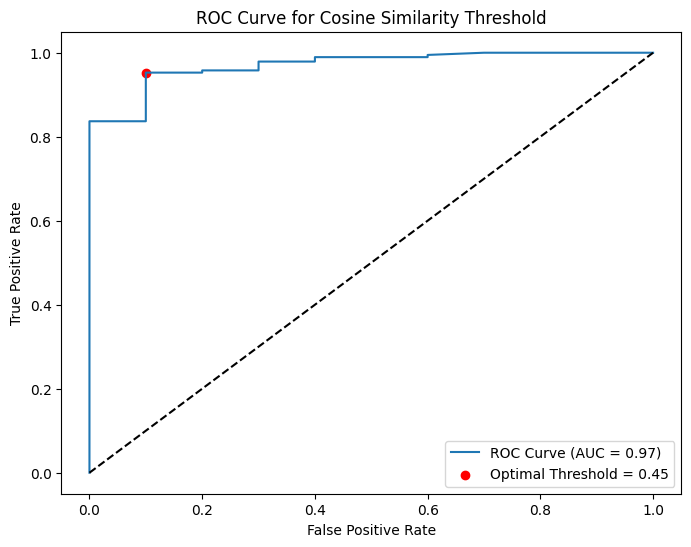

The optimal threshold is: 0.44664112


In [110]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Extract ground truth and cosine similarity scores
y_true = ROC_validation_df['correct']  # Replace with the actual column indicating ground truth correctness
y_scores = ROC_validation_df['cosine_similarity']

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

# Determine the optimal threshold
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random chance
plt.scatter(fpr[optimal_idx], tpr[optimal_idx], marker='o', color='red', label=f'Optimal Threshold = {optimal_threshold:.2f}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Cosine Similarity Threshold')
plt.legend(loc='lower right')
plt.show()

print(f"The optimal threshold is: {optimal_threshold}")

In [111]:
# find correct answers using new threshold:
df['prediction'] = df['cosine_similarity'].apply(lambda x: 'correct' if x > optimal_threshold else 'incorrect')
df.head()

,title,context,question,answer,predicted_answer,cosine_similarity,prediction
0,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,When did Beyonce start becoming popular?,in the late 1990s,late 1990s,0.881793,correct
1,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,What areas did Beyonce compete in when she was...,singing and dancing,singing and dancing,1.000000,correct
2,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,When did Beyonce leave Destiny's Child and bec...,2003,2003,1.000000,correct
3,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,In what city and state did Beyonce grow up?,"Houston, Texas",Houston,0.707107,correct
4,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,In which decade did Beyonce become famous?,late 1990s,1990s,0.727777,correct


In [112]:
# Calculate accuracy
total_predictions = len(df)
correct_predictions = len(df[df['prediction'] == 'correct'])
accuracy = correct_predictions / total_predictions

print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.95


In [114]:
# Calculate accuracy by topic
accuracy_by_topic = df.groupby('title').apply(lambda x: (x['prediction'] == 'correct').mean())

# Sort the accuracy by topic
sorted_accuracy_by_topic = accuracy_by_topic.sort_values(ascending=False)

# Display the sorted accuracy as a table
sorted_accuracy_by_topic_df = sorted_accuracy_by_topic.reset_index()
sorted_accuracy_by_topic_df.columns = ['Topic', 'Accuracy']

print(sorted_accuracy_by_topic_df)

                               Topic  Accuracy
0                           Napoleon  0.993119
1               Dwight_D._Eisenhower  0.981395
2                        Middle_Ages  0.977876
3                 Hellenistic_period  0.977273
4            2008_Sichuan_earthquake  0.973129
5                                Dog  0.971939
6                        Southampton  0.971831
7   2008_Summer_Olympics_torch_relay  0.968000
8                             Greece  0.967980
9                      New_York_City  0.965728
10                   Frédéric_Chopin  0.961263
11                     American_Idol  0.956962
12                    Roman_Republic  0.956633
13                           Beyoncé  0.956175
14                    Queen_Victoria  0.955687
15            New_Haven,_Connecticut  0.953608
16          Religion_in_ancient_Rome  0.948148
17                    Modern_history  0.946429
18                Gamal_Abdel_Nasser  0.939954
19                          Buddhism  0.936066
20           

/tmp/ipykernel_4019/2008860014.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  accuracy_by_topic = df.groupby('title').apply(lambda x: (x['prediction'] == 'correct').mean())
